# Dermoscopic Skin Lesion Image Classifier

This notebook walks through the steps needed to create a Convolutional Neural Network to classify dermoscopic skin lesion images. The CNN was trained using the HAM10000 dataset, along with some data augmentation to attempt to remedy the problem of imbalanced classes within the aforementioned dataset.

To view the exploratory data analysis done on this dataset, my notebook publicly available [here](https://github.com/hasib-a/ham10000_exploratory_data_analysis/blob/master/exploratory-data-analysis-ham10000.ipynb).

The dataset is publicly available to download over at [Harvard Dataverse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T).

This CNN model will attempt to detect 7 different classes of skin cancer:
- Actinic keratoses
- Basal cell carcinoma
- Benign keratosis
- Dermatofibroma
- Melanoma
- Melanocytic nevi
- Vascular lesions

#### HAM10000 Dataset
The HAM10000 dataset includes a representative collection of all important diagnostic categories in the realm of pigmented lesions: Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec), basal cell carcinoma (bcc), benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), dermatofibroma (df), melanoma (mel), melanocytic nevi (nv) and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).

In [2]:
# all imports needed here
from glob import glob
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
import pickle
import h5py


import keras
from keras.applications import MobileNet
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy


Using TensorFlow backend.


In [3]:
base_directory = '/home/ah2020/skin_lesion_classification/ham10000_dataset'

# create dict of image path
files_list = glob('/home/ah2020/skin_lesion_classification/ham10000_dataset/*.jpg')

img_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in files_list}

# Categories of the diferent skin lesions
lesion_types_dict = {
    'akiec': 'Actinic keratoses',
    'bcc': 'Basal cell carcinoma',
    'bkl': 'Benign keratosis',
    'df': 'Dermatofibroma',
    'mel': 'Melanoma',
    'nv': 'Melanocytic nevi',
    'vasc': 'Vascular lesions',
}

### Read in and process data

Now to read in the metadata CSV file by using pandas. Then creation of new columns for readability purposes later in the notebook.

- cell_type has the human readable name of the lesion
- cell_type_idx categorises the lesion types into codes from 0-6

In [4]:
df = pd.read_csv(os.path.join(base_directory, 'HAM10000_metadata.csv'))

# creation of new columns for readability later
df['path'] = df['image_id'].map(img_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_types_dict.get) 
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

In [5]:
df['age'].fillna((df['age'].mean()), inplace=True) # because None values not supported.

### Resize the images

Images to be loaded into the dataframe at column 'image' from the image path, then resize the images to 224x224 as MobileNet cannot handle the original image dimesions (450x600)

In [6]:
# already ran this before
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((224,224))))

In [7]:
df['image'].map(lambda x: x.shape).value_counts()

(224, 224, 3)    10015
Name: image, dtype: int64

In [8]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/home/ah2020/skin_lesion_classification/ham100...,Benign keratosis,2,"[[[187, 152, 194], [190, 155, 197], [192, 155,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/home/ah2020/skin_lesion_classification/ham100...,Benign keratosis,2,"[[[23, 12, 20], [24, 12, 22], [26, 15, 23], [2..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/home/ah2020/skin_lesion_classification/ham100...,Benign keratosis,2,"[[[185, 126, 132], [188, 128, 136], [191, 135,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/home/ah2020/skin_lesion_classification/ham100...,Benign keratosis,2,"[[[23, 11, 15], [24, 11, 20], [23, 10, 19], [2..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/home/ah2020/skin_lesion_classification/ham100...,Benign keratosis,2,"[[[126, 84, 106], [133, 91, 113], [140, 92, 11..."


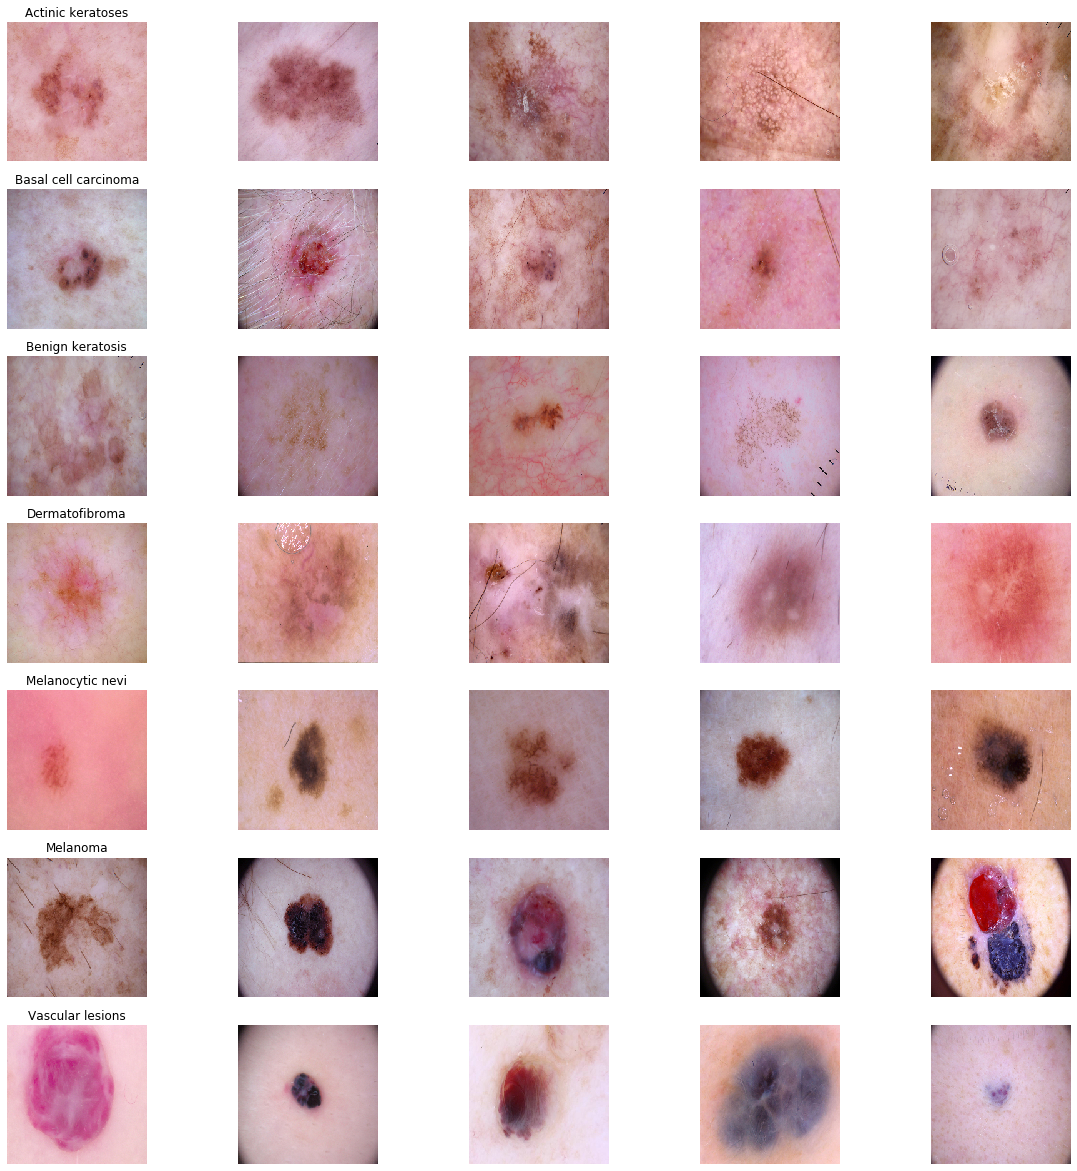

In [9]:
samples = 5
fig, m_axes = plt.subplots(7, samples, figsize = (4*samples, 3*7))
for n_axes, (type_name, type_rows) in zip(m_axes, 
                                         df.sort_values(['cell_type']).groupby('cell_type')):
    n_axes[0].set_title(type_name)
    for col_ax, (_, c_row) in zip(n_axes, type_rows.sample(samples, random_state=100).iterrows()):
        col_ax.imshow(c_row['image'])
        col_ax.axis('off')
fig.savefig('category_lesion_samples.png', dpi=450)

### Create the feature set and labels

In [10]:
features=df.drop(columns=['cell_type_idx'],axis=1)
labels=df['cell_type_idx']

### Training and testing split

Splitting the dataset into 80% training and 20% testing, setting random state to 1234 for reproducability rather than the default RandomState instance used by np.random


In [11]:
x_train_, x_test_, y_train_, y_test_ = train_test_split(features, labels, test_size=0.20,random_state=1234)

### Normalise features

Normalisation of the x_train & x_test by the following method:


(x_train - x_train_mean) / x_train_std_dev

(x_test - x_test_mean) / x_test_std_dev

In [12]:
x_train = np.asarray(x_train_['image'].tolist())
x_test = np.asarray(x_test_['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

We have 7 classes (skin lesion types from 0-6) and using a binary loss this will not work.

To allow me to use a binary loss, I will have to create one-hot vectors from the class indices as per [keras docs](ps://www.tensorflow.org/guide/keras/train_and_evaluate)

In [13]:
# Creating one-hot vectors on the class indices
y_train = to_categorical(y_train_, num_classes = 7)
y_test = to_categorical(y_test_, num_classes = 7)

### Create validation set

I have chosen a 90/10 split on the training set; 90% to train the model and 10% to be used for a validation set which the model will be evaluated by.

In [14]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, 
                                                            test_size = 0.1, 
                                                            random_state = 2)
# setting random_state to 2 for reproducability, rather than the default RandomState instance used by np.random

### Create the CNN model

Creation of the CNN model using a pre-trained model, then adding my own layers after the initial pre-trained model. Creation of the model was done with code adapted from [machinelearningmastery](https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/).

In [15]:
mobile = MobileNet()

In [16]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

### Feature Extraction

In this step, I will freeze the convolutional base created from the previous step and to use as a feature extractor. I have also removed the last 5 layers which include the activation layer. Then add my own fully connected Dense layer with the softmax activation as the prediction layer.

In [17]:
mobile_less_5 = mobile.layers[-6].output

mobile_less_5 = Dropout(0.25)(mobile_less_5)
predictions = Dense(7, activation='softmax')(mobile_less_5)
model = Model(inputs=mobile.input, outputs=predictions)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. By freezing (by setting layer.trainable = False) it prevents the weights in a given layer from being updated during training. MobileNet v1 has many layers, so setting the entire model's trainable flag to False will freeze all the layers.

I am freezing the weights from all layers apart from the last 25 layers which I want to train, to be able to use the low level features (such as curves, edges and shapes) learned via MobileNet to help make my classification more accurate.

In [92]:
# Here I will choose how many layers i want to train
# I will be freezing the weights from all layers apart from the last 25
# which will be trained

for layer in model.layers[:-25]:
    layer.trainable = False

### Compile model now

In [95]:
model.compile(optimizer = 'adam', loss='categorical_crossentropy', 
              metrics=["accuracy"])

### Setting a learning rate annealer

To allow the optimiser to converge faster and get as close to the global min of the loss function, I have implemented a simulated annealing method of the learning rate.

Learning rate here refers to the step that the optimiser walks through the "loss landscape". The higher the learning rate the bigger the steps are, and this means quicker convergence. High learning rate also offers fast computation time when compared to a comparatively lower learning rate. It is important to note that a higher learning rate results in poor sampling.

I have used a decreasing learning rate during the training of my CNN to allow it to reach the global minimum of the loss function. I initially started with a high learning rate, then decreased the learning rate dynamically every X epochs (steps) if the accuracy did not improve.

Using the function ReduceLROnPlateau() from keras.callbacks, I opted to reduce the learning rate by a quarter (25%) if the accuracy did not improve after 3 epochs.

Code for the learning rate was based on the [Keras Python Docs](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau).


In [100]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.25, 
                                            min_lr=0.00001)

### Data augmentation

Following the exploratory data analysis I did on the dataset, I indentified the need to artifically expand the HAM10000 dataset in order to avoid the model overfitting.

This essentially makes the dataset larger, altering the training data with minor transformations to produce variations within the images. Artifically making the dataset larger results in more training data which will enable me to create a more robust model.

For this data augmentation I chose to:

   - rotate some images by 20 degrees randomly
   - zoom some images by 10% randomly
   - shift some of the images horizontally by 10% randomly
   - shift some of the images vertically by 10% randomly
   - flip some images horizontally = True
   - flip some images vertically = False

More augmentations can be done with the ImageDataGenerator() for more variability within the training dataset if needed in the future.


In [101]:
datagen = ImageDataGenerator(
        rotation_range=20,  # rotate images between 0-180 degrees randomly
        zoom_range = 0.1, # zoom image randomly
        width_shift_range=0.1,  # shift images horizontally (the input is a fraction of total width) randomly
        height_shift_range=0.1,  # shift images vertically (thei nput is a fraction of total height) randomly
        horizontal_flip=True,  # flip images horizontally randomly
        vertical_flip=False)  # flip images vertically randomly

datagen.fit(x_train)

### Fit the model

Fit x_train, y_train to the model. I have decided on a batch size of 10, as a smaller batch size *can* be more efficient in training the model and I have chosen 50 epochs to allow the model ample time time to train.


In [102]:
batch_size = 10
epochs = 50 
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size,
                              callbacks=[learning_rate_reduction])

Epoch 1/50
721/721 [==============================] - 113s 156ms/step - loss: 0.1691 - accuracy: 0.9376 - val_loss: 3.1899 - val_accuracy: 0.6658
Epoch 2/50
721/721 [==============================] - 111s 153ms/step - loss: 0.1778 - accuracy: 0.9355 - val_loss: 4.6602 - val_accuracy: 0.3815
Epoch 3/50
721/721 [==============================] - 112s 155ms/step - loss: 0.1580 - accuracy: 0.9427 - val_loss: 1.8290 - val_accuracy: 0.6970
Epoch 4/50
721/721 [==============================] - 110s 152ms/step - loss: 0.1567 - accuracy: 0.9423 - val_loss: 2.1026 - val_accuracy: 0.6584
Epoch 5/50
721/721 [==============================] - 109s 151ms/step - loss: 0.1597 - accuracy: 0.9433 - val_loss: 1.3210 - val_accuracy: 0.6783
Epoch 6/50
721/721 [==============================] - 109s 151ms/step - loss: 0.1377 - accuracy: 0.9505 - val_loss: 1.9818 - val_accuracy: 0.7357
Epoch 7/50
721/721 [==============================] - 109s 151ms/step - loss: 0.1391 - accuracy: 0.9502 - val_loss: 2.3674 -

### Evaluate model performance and see model history values

In [103]:
print('history dict:', history.history)

history dict: {'val_loss': [3.189861174361264, 4.660232017759671, 1.8290004787227474, 2.1025511079138037, 1.320984612337483, 1.9818465036376056, 2.367415962099769, 3.879166285972389, 3.5533946551988715, 2.0535000387086835, 2.02734849191366, 2.29186400343772, 2.3988641603551386, 2.3131028695930227, 2.350782151293344, 2.3098519277965597, 2.2776946854821762, 2.307459142718968, 2.218855911228304, 2.257770069423097, 2.2250350324663177, 2.262861104754376, 2.209947989191024, 2.287912750369904, 2.2945249586528984, 2.2733471773460594, 2.2866433941083613, 2.278382987207838, 2.2541607763729132, 2.2738488254542615, 2.294369135286538, 2.270746386951379, 2.2017815741293765, 2.2711103765210927, 2.2259080448621034, 2.2188243587330643, 2.2293240269103163, 2.2302598461437335, 2.26583690305201, 2.2504490553648178, 2.260307047407821, 2.2602789142137705, 2.283524254373097, 2.2315973537031124, 2.2294184628809033, 2.21750631302443, 2.240944924027522, 2.1580228664978476, 2.20881797131958, 2.2187371513039276],

In [104]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(x_test, y_test, batch_size=96)
print('test loss, test acc:', results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions for 3 samples')
predictions = model.predict(x_test[:3])
print('predictions shape:', predictions.shape)



# Evaluate on test data
2003/2003 [==============================] - 22s 11ms/step
test loss, test acc: [2.3463638176396677, 0.7039440870285034]

# Generate predictions for 3 samples
predictions shape: (3, 7)


### Export model as a HD5 file. This saves the whole model architecture and associated weights and optimiser state

In [106]:
model.save('skin_lesion_image_classifier_model_wtl.h5') 
# saves file as a HDF5 file, Saving/loading whole models 
#(architecture + weights + optimiser state)

In [107]:
model.metrics_names

['loss', 'accuracy']

In [108]:
x_validate.shape

(802, 224, 224, 3)

In [109]:
type(x_validate)

numpy.ndarray

### Create analytics for the model training and evaluation process

Code for the creation of the model accuracy and model loss were based on the guide from [pluralsight](https://www.pluralsight.com/guides/data-visualization-deep-learning-model-using-matplotlib).

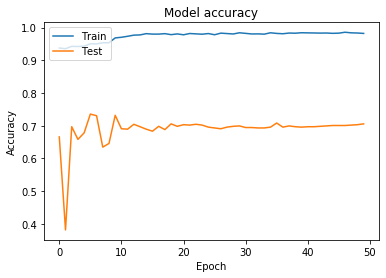

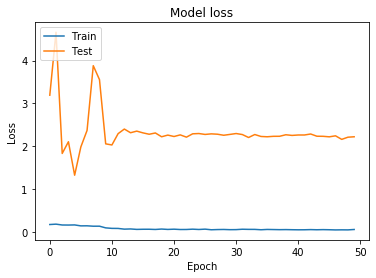

In [111]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Plot the confusion matrix

The code to create the confusion matrix was retrieved from the [scikit-learn examples](https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html).

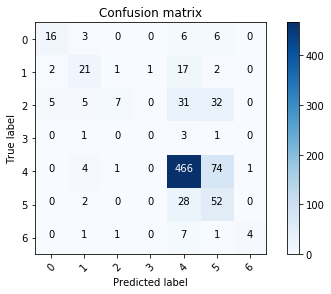

<Figure size 1080x1080 with 0 Axes>

In [112]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    If you want normalisation to be applied then you can do so by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.figure(figsize=(15,15))

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))

### Now to plot which categories had the most incorrect predictions

Text(0, 0.5, 'Fraction of Incorrect Classifications')

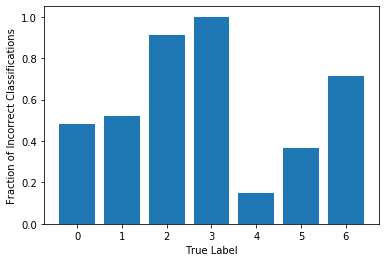

In [113]:
label_fraction_err = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_fraction_err)
plt.xlabel('True Label')
plt.ylabel('Fraction of Incorrect Classifications')

### Incorrect classification results

As we can see from the plot above, the model has the most incorrect predictions for

The top 3 incorrect predictions:

    Dematofibroma (class 3)
    Benign keratosis (class 2)
    Vascular lesion (class 6)

The model had the least incorrect predictions for Melanoma (class 4), which is to be assumed as it had the the most images for that particular skin lesion in the HAM10000 dataset.

Table below for reference on the code -> skin lesion name

| Lesion Name | Code |
|--|--|
|Actinic keratoses | 0 |
|Basal cell carcinoma | 1 |
|Benign keratosis | 2 |
|Dermatofibroma | 3 |
|Melanoma | 4 |
|Melanocytic nevi | 5 |
|Vascular lesion | 6 |


### Save model as a pickle file also

In [115]:
# save model as pickle file
import pickle
# save the model to disk
filename = 'skin_lesion_image_classifier_model_wtl.sav'
pickle.dump(model, open(filename, 'wb'))